# Install Transformers Library

In [70]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# specify GPU
#device = torch.device("cuda")

# Load Dataset

In [120]:
df = pd.read_csv("relevance_score_with_news.csv")
df.tail()

,Unnamed: 0,news,url,relevance
315,315,EMERGING MARKETS-Global slowdown concerns spar...,https://finance.yahoo.com/news/emerging-market...,0
316,316,Will be right back...,https://finance.yahoo.com/m/e71b3da5-6578-300c...,0
317,317,Will be right back...,https://finance.yahoo.com/m/f5c23228-eed5-33bf...,0
318,318,Will be right back...,https://finance.yahoo.com/m/57faf6ff-34ba-37b7...,0
319,319,Will be right back...,https://finance.yahoo.com/m/23aa08b8-3c59-31b9...,0


In [121]:
df = df[['news','relevance']]
df = df.rename(columns={"news":"text"})
df = df.rename(columns={"relevance":"label"})
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.tail()

,label,text
315,0,EMERGING MARKETS-Global slowdown concerns spar...
316,0,Will be right back...
317,0,Will be right back...
318,0,Will be right back...
319,0,Will be right back...


In [74]:
df.shape

(994, 2)

In [123]:
df = df.drop_duplicates()

In [124]:
df.shape

(252, 2)

In [125]:
df['label'].value_counts()

0    136
1    116
Name: label, dtype: int64

# Split train dataset into train, validation and test sets

In [127]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [129]:
len(temp_text)

76

# Import BERT Model and BERT Tokenizer

In [130]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('ProsusAI/finbert')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('ProsusAI/finbert')

Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [131]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [132]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

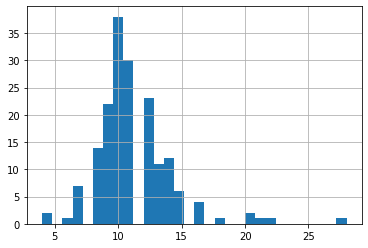

In [133]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [134]:
max_seq_len = 40

In [135]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [136]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [137]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [138]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [139]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask,return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [140]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
#model = model.to(device)

In [141]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Find Class Weights

In [142]:
#Rebalnce the Dataset

class_wts= compute_class_weight(class_weight = "balanced",classes = np.unique(train_labels),y=train_labels)
class_weights = dict(zip(np.unique(train_labels), class_wts))
class_weights

print(class_wts)

[0.92631579 1.08641975]


In [143]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
#weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [144]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    #batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [145]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    #batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [146]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights_relevance.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.779
Validation Loss: 0.527

 Epoch 2 / 10

Evaluating...

Training Loss: 0.587
Validation Loss: 0.378

 Epoch 3 / 10

Evaluating...

Training Loss: 0.514
Validation Loss: 0.300

 Epoch 4 / 10

Evaluating...

Training Loss: 0.514
Validation Loss: 0.288

 Epoch 5 / 10

Evaluating...

Training Loss: 0.451
Validation Loss: 0.293

 Epoch 6 / 10

Evaluating...

Training Loss: 0.471
Validation Loss: 0.293

 Epoch 7 / 10

Evaluating...

Training Loss: 0.412
Validation Loss: 0.300

 Epoch 8 / 10

Evaluating...

Training Loss: 0.427
Validation Loss: 0.276

 Epoch 9 / 10

Evaluating...

Training Loss: 0.434
Validation Loss: 0.295

 Epoch 10 / 10

Evaluating...

Training Loss: 0.397
Validation Loss: 0.242


# Load Saved Model

In [147]:
#load weights of best model
path = 'saved_weights_strenght.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Val Data

In [148]:
# get predictions for val data
with torch.no_grad():
  logits = model(val_seq, val_mask)
  probs = F.softmax(logits, dim=1) # assuming logits has the shape [batch_size, nb_classes]
  preds = logits.detach().cpu().numpy()

In [149]:
# Probability of each of the classes [normal,abnormal]
probs

tensor([[0.4856, 0.5144],
        [0.4695, 0.5305],
        [0.4556, 0.5444],
        [0.4577, 0.5423],
        [0.0948, 0.9052],
        [0.4787, 0.5213],
        [0.4816, 0.5184],
        [0.5899, 0.4101],
        [0.1936, 0.8064],
        [0.7385, 0.2615],
        [0.4687, 0.5313],
        [0.5748, 0.4252],
        [0.4671, 0.5329],
        [0.4511, 0.5489],
        [0.4573, 0.5427],
        [0.4513, 0.5487],
        [0.4448, 0.5552],
        [0.3997, 0.6003],
        [0.4488, 0.5512],
        [0.6627, 0.3373],
        [0.5903, 0.4097],
        [0.2254, 0.7746],
        [0.1194, 0.8806],
        [0.5624, 0.4376],
        [0.6882, 0.3118],
        [0.2169, 0.7831],
        [0.4222, 0.5778],
        [0.4476, 0.5524],
        [0.4698, 0.5302],
        [0.3244, 0.6756],
        [0.4488, 0.5512],
        [0.4381, 0.5619],
        [0.5120, 0.4880],
        [0.4546, 0.5454],
        [0.4475, 0.5525],
        [0.1039, 0.8961],
        [0.3119, 0.6881],
        [0.4250, 0.5750]])

In [150]:
# predictions based on the highest probabilities
preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [151]:
# model's performance
print(classification_report(val_y, preds))
print(f"roc_auc:{roc_auc_score(val_y, probs[:,1])}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.33      0.56      0.42        18

    accuracy                           0.26        38
   macro avg       0.17      0.28      0.21        38
weighted avg       0.16      0.26      0.20        38

roc_auc:0.24722222222222223


# Get Predictions for Test Data

In [152]:
# get predictions for val data
with torch.no_grad():
  logits = model(test_seq, test_mask)
  probs = F.softmax(logits, dim=1) # assuming logits has the shape [batch_size, nb_classes]
  preds = logits.detach().cpu().numpy()

In [156]:
# Probability of each of the classes [neutral,positive,negative]
probs

tensor([[0.1005, 0.8995],
        [0.4160, 0.5840],
        [0.4756, 0.5244],
        [0.4306, 0.5694],
        [0.5615, 0.4385],
        [0.4631, 0.5369],
        [0.4783, 0.5217],
        [0.6175, 0.3825],
        [0.6677, 0.3323],
        [0.4946, 0.5054],
        [0.1920, 0.8080],
        [0.4520, 0.5480],
        [0.4427, 0.5573],
        [0.4469, 0.5531],
        [0.1002, 0.8998],
        [0.5344, 0.4656],
        [0.4609, 0.5391],
        [0.4433, 0.5567],
        [0.5438, 0.4562],
        [0.1502, 0.8498],
        [0.1381, 0.8619],
        [0.5320, 0.4680],
        [0.4913, 0.5087],
        [0.4499, 0.5501],
        [0.4839, 0.5161],
        [0.6418, 0.3582],
        [0.2700, 0.7300],
        [0.4647, 0.5353],
        [0.3915, 0.6085],
        [0.1331, 0.8669],
        [0.4528, 0.5472],
        [0.3141, 0.6859],
        [0.5503, 0.4497],
        [0.4490, 0.5510],
        [0.0920, 0.9080],
        [0.4492, 0.5508],
        [0.4494, 0.5506],
        [0.4862, 0.5138]])

In [154]:
# predictions based on the highest probabilities
preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])

In [155]:
# model's performance
# model's performance
print(classification_report(test_y, preds))
print(f"roc_auc:{roc_auc_score(test_y, probs[:,1])}")

              precision    recall  f1-score   support

           0       0.25      0.10      0.14        21
           1       0.37      0.65      0.47        17

    accuracy                           0.34        38
   macro avg       0.31      0.37      0.30        38
weighted avg       0.30      0.34      0.29        38

roc_auc:0.23249299719887956


In [119]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,50,28
1,55,17
